In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import copy

In [6]:
#This function converts a CSV file to two numpy arrays for features and response
def csv_to_arrs(filename, response_name):
    #Importing CSV as Pandas dataframe
    dataframe = pd.read_csv(filename)
    
    #Splitting dataframe into x and y
    response = dataframe[response_name]
    features = dataframe.drop([response_name],axis=1)
    
    #Converting datagrames to numpy array
    response_arr = response.to_numpy(dtype='float64')
    features_arr = features.to_numpy()
    
    features_arr[features_arr == 'Male'] = 1
    features_arr[features_arr == 'Female'] = 0
    features_arr[features_arr == 'Yes'] = 1
    features_arr[features_arr == 'No'] = 0
    features_arr = features_arr.astype('float64')

    return list(dataframe.columns), features_arr, response_arr


#Function to center data
def center_data(data):
    #Finding the mean column-wise
    data_mean = np.mean(data,axis=0)
    cent_data = np.subtract(data,data_mean)
        
    return cent_data, data_mean


#Function to standardize data    
def normalize_data(data):
    #Finding the mean and standard deviation column-wise
    cent_data, data_mean = center_data(data)
    data_std = np.std(cent_data,axis=0)
    norm_data = np.divide(cent_data,data_std)

    return norm_data, data_mean, data_std


#Ridge regression main algorithm
def ridge_regression(x_train, y_train, param_l, alpha, epoch, verbose):
    iteration = 1
    
    #Initializing random beta values
    beta = np.random.rand(x_train.shape[1], 1) - 0.5
    
    #Saving standard deviation, mean of x and mean of y
    x_norm, x_mean, x_std = normalize_data(x_train)
    y_cent, y_mean = center_data(y_train)
    
    while iteration <= epoch:
        beta_prev = copy.deepcopy(beta)
        
        #Gradient descent calculation
        beta = beta - 2*alpha*(np.subtract(param_l*beta,np.matmul(x_norm.T,(np.subtract(y_cent,np.matmul(x_norm,beta))))))
        
        if iteration%1000 == 0 and verbose == 1:
            print(f'Currently on epoch {iteration}!')
        
        #Exiting if it converges
        comparison = beta_prev == beta
        if comparison.all():
            if verbose == 1:
                print(f'The model converged at epoch {iteration}!')
            break
            
        iteration += 1
        
    return beta, x_mean, x_std, y_mean


#Finding the MSE of the regression algorithm
def evaluate_regression(beta, x_mean, x_std, y_mean, x_test, y_test):
    #Standardizing test feature set with training set values
    x_test = np.divide(np.subtract(x_test,x_mean),x_std)
    y_pred = np.matmul(x_test,beta)
    
    #Centering test response set with training set values
    y_test = np.subtract(y_test,y_mean)
    
    #Finding the MSE of the regression algorithm
    mse = (1/y_pred.shape[0])*(np.sum(pow(np.subtract(y_test,y_pred),2)))
    
    return mse
    

#k-fold cross validation algorithm
def k_fold_cv(x, y, n, param_l, alpha, epoch):
    #An array to store the MSE of each run
    results = []
    
    #Zipping the data, shuffling it to randomize it, and then splitting the data into equal chunks
    data = np.column_stack((x,y))
    np.random.shuffle(data)
    data = np.split(data,n,axis=0)
    
    #For each split...
    for i, split in enumerate(data):
        #Separate response and feature validation sets from the ith split
        y_valid = split[:,-1]
        y_valid = np.reshape(y_valid,(y_valid.shape[0],1))   
        x_valid = np.delete(split,-1,axis=1)
        
        #Combine the remaining chunks
        train_data_list = data[:i] + data[i+1:]
        train_data = train_data_list[0]
        for j in range(1,len(train_data_list)):
            train_data = np.concatenate((train_data,train_data_list[j]),axis=0)
        
        #Separate response and feature training sets from the rest of the data
        y_train = train_data[:,-1]
        y_train = np.reshape(y_train,(y_train.shape[0],1))   
        x_train = np.delete(train_data,-1,axis=1)
        
        #Perform the regression and obtain beta values
        beta, x_mean, x_std, y_mean = ridge_regression(x_train,y_train,param_l,alpha,epoch,0)
        print(beta.shape)
        
        #Evaluate the regression
        error = evaluate_regression(beta,x_mean,x_std,y_mean,x_valid,y_valid)
        results.append(error)
    
    #Find the MSE of the k-fold cross validation
    cv_mse = (1/n)*(sum(results))
    
    return cv_mse, beta

In [7]:
#Set the filepath here
filepath = 'dataset.csv'

#Getting the dataset from the CSV file
labels, x, y = csv_to_arrs(filepath, 'Balance')

#Setting some parameters to run the regression
alpha = 0.00001
epochs = 100000
mse_arr = []
beta_arr = []
param_l_arr = [0.01, 0.1, 1, 10, 100, 1000, 10000]

x_norm, _, _ = normalize_data(x)
print(x_norm)

#For each lambda in the lambda parameter array...
for param_l in param_l_arr:
    print(f'Current lambda parameter is {param_l}')
    
    #Perform k-fold cross validation with said lambda value
    mse, beta = k_fold_cv(x,y,5,param_l,alpha,epochs)
    
    #Append results to arrays to access for plotting
    mse_arr.append(mse)
    beta_arr.append(beta)

[[-0.86158299 -0.48999879 -0.46553881 ...  1.03563452 -0.33333333
   0.79539491]
 [ 1.72743711  0.82826106  0.82870309 ... -0.96559161  3.
   0.79539491]
 [ 1.68675551  1.01478681  1.02931059 ...  1.03563452 -0.33333333
  -1.25723711]
 ...
 [ 0.35946155 -0.24491264 -0.21963285 ... -0.96559161 -0.33333333
   0.79539491]
 [-0.21280808 -0.95891584 -1.05441888 ...  1.03563452 -0.33333333
   0.79539491]
 [-0.75334493  0.34199278  0.38866085 ... -0.96559161 -0.33333333
  -1.25723711]]
Current lambda parameter is 0.01
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
Current lambda parameter is 0.1
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
Current lambda parameter is 1
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
Current lambda parameter is 10
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
Current lambda parameter is 100
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
Current lambda parameter is 1000
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)
Current lambda parameter is 10000
(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)


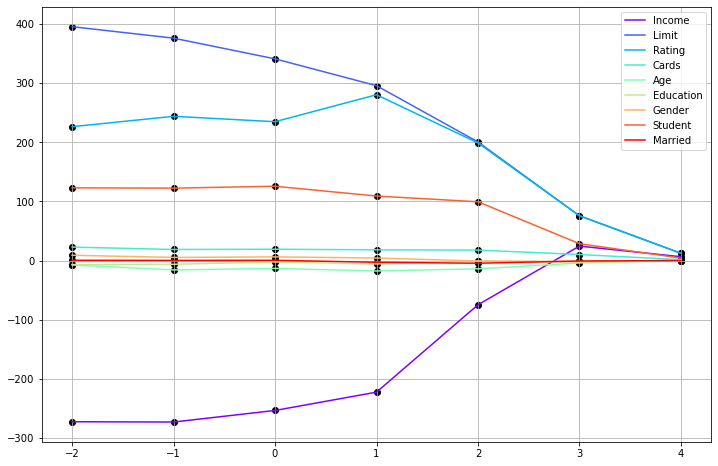

In [8]:
#Finding the log10 of the lambda values for plotting
param_l_log = np.log10(param_l_arr)

#Getting an array of pseudo-continuous values
param_l_log_smooth = np.linspace(param_l_log.min(),param_l_log.max(),500) 

#Setting equally-spaced color values
color_spacing = np.linspace(0,1,x.shape[1])
colors = [cm.rainbow(param_l_log_smooth) for param_l_log_smooth in color_spacing]

#Removing the response from the labels
fig_labels = labels[:-1]

#Creating the figure
fig0, ax0 = plt.subplots(figsize=[12,8])

#For each feature i...
for i in range(x.shape[1]):
    beta_i = []
    
    #For each lambda value...
    for j in range(len(param_l_arr)):
        betas_for_lambda = beta_arr[j]
        
        #Append beta value for feature i to an array
        beta_i.append(betas_for_lambda[i])
    
    #Plotting the beta values for feature i for each lambda 
    ax0.plot(param_l_log,beta_i,label=fig_labels[i],color=colors[i])
    ax0.scatter(param_l_log,beta_i,color='k')

ax0.legend(fig_labels,loc='upper right')
ax0.grid()

==== The lambda value that provides the minimum MSE is 1 with an MSE of 10109.39 ====


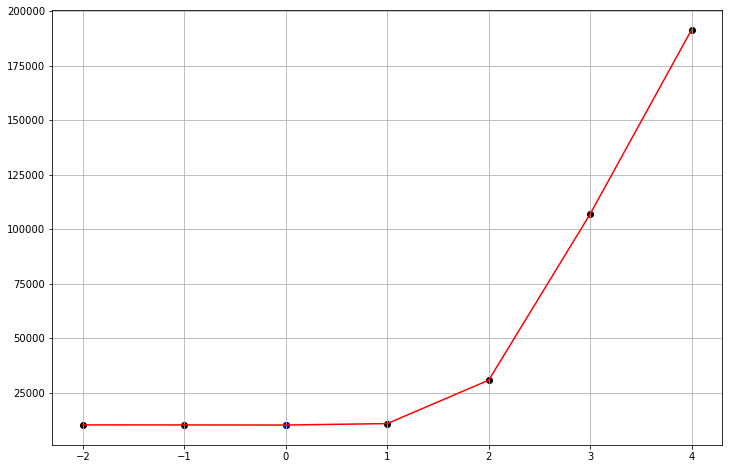

In [9]:
#Finding the minimum lambda based on the minimum MSE result from the k-fold cross validation
min_l = param_l_arr[mse_arr.index(min(mse_arr))]
min_mse = mse_arr[mse_arr.index(min(mse_arr))]
    
print(f'==== The lambda value that provides the minimum MSE is {min_l} with an MSE of {round(min_mse,3)} ====')

#Plotting the MSE that corresponds to each lambda value
fig1, ax1 = plt.subplots(figsize=[12,8])
ax1.scatter(param_l_log,mse_arr,color='k')
ax1.scatter(param_l_log[mse_arr.index(min(mse_arr))],mse_arr[mse_arr.index(min(mse_arr))],color='b')
ax1.plot(param_l_log,mse_arr,color='r')
ax1.grid()

In [10]:
#Training a model according to the best lambda value on the entire dataset to obtain the optimal beta values
y = np.reshape(y,(y.shape[0],1)) 
beta, x_mean, x_std, y_mean = ridge_regression(x,y,min_l,alpha,epochs,0)

print(f'\nThe beta values learned using the best lambda value {min_l} are:\n{np.round(beta,3)}')


The beta values learned using the best lambda value 1 are:
[[-271.235]
 [ 367.99 ]
 [ 244.146]
 [  21.426]
 [ -11.272]
 [  -3.037]
 [   5.094]
 [ 127.069]
 [  -3.986]]
